# Transformers for BoolQ reading comprehension

## Sources

My sources for this project are linked in the respecting sections of the notebook. I used AI tools such as ChatGPT to correct my writing and grammar in stage 1 of this project and plan on using it for debugging during stage 2.

## Setup

### **Importing Python Packages**
Making sure the notebook is reproducible and runs without error, I will install the necessary libraries in a pip cell below.

### **Data Loading and Split**
The BoolQ dataset contains binary question-answer pairs. Each entry consists of a question, a passage, and the corresponding binary answer (yes/no). The dataset is split as required by the course materials:
- **Train Split:** The first 8427 entries of the training data.
- **Validation Split:** The last 1000 entries of the training data.
- **Test Split:** The validation split provided in the BoolQ dataset (3270 entries).

### **Seeding for Reproducibility**
A seed value of 42 is used to ensure reproducibility of results across different runs.

### **Batch size**
Setting the batch size in the beginning of the notebook for use throughout the code.

In [1]:
# TODO: install all necessary packages
# %pip install -q 

In [2]:
# TODO: import libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from datasets import load_dataset
from typing import Any, Dict
import lightning.pytorch as pl
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import optuna
from optuna.integration import PyTorchLightningPruningCallback

import wandb


C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# TODO: set random seed to 42
pl.seed_everything(42, workers=True)

Seed set to 42


42

In [4]:
# TODO: set constants for projects
BATCH_SIZE: int = 32
MAX_SEQ_LENGTH: int = 512
MODEL_NAME: str = "bert-base-cased"

print(f"Batch size: {BATCH_SIZE}"
      f"\nMax seq length: {MAX_SEQ_LENGTH}"
      f"\nModel Name: {MODEL_NAME}")

Batch size: 32
Max seq length: 512
Model Name: bert-base-cased


## Preprocessing

### Tokenizer
In this project, the `AutoTokenizer` from the Hugging Face Transformers library is used to handle text preprocessing. Specifically, the `bert-base-cased` associated with the "bert-base-cased" model is instantiated. This tokenizer manages:
- Whitespace and special character removal.
- Retaining case sensitivity to preserve semantic meaning.
- Padding and truncation to ensure sequences are within the 512-token limit.

##### Tokenization Details
- **Questions:** The length of questions is capped at 21 tokens, based on dataset analysis.
- **Passages:** Passages are padded or truncated to ensure the overall sequence remains within the 512-token limit.


#### Handling OOV words
The BERT Tokenizer utilizes a WordPiece tokenization strategy. Words not present in the vocabulary are decomposed into subword units. For example, an unknown word like "unhappiness" might be tokenized into "un", "##happiness". This approach ensures that even unseen words are represented through known subword components.


#### Padding and Truncation
Sequences are padded to a maximum length of 512 tokens, aligning with BERT's architecture constraints. Padding is applied to the maximum sequence length, not just the length of the longest sequence in a batch. This approach ensures consistent input dimensions across all batches, prioritizing simplicity and uniformity over computational efficiency. While dynamic batch padding could improve efficiency and reduce memory usage, the focus of this project is not on optimizing transformer models for efficiency. Therefore, fixed padding is used to streamline implementation and maintain uniformity.


#### Case Sensitivity
The "bert-base-cased" tokenizer is case-sensitive, distinguishing between words like "Apple" and "apple". This sensitivity preserves the semantic nuances of the text.


### Embedding Layer
The model leverages the pre-trained embeddings form the "bert-base-cased" model. These embeddings are fine-tuned during training to adapt to the specific nuances of the BoolQ dataset.


### Positional Embeddings
BERT inherently incorporates positional embeddings, unlike the transformer encoder in the last project, to capture the order of tokens in a sequence.


### Input / Output / Label Format
Each data point consists of a question, passage, and binary label (True/False). The preprocessing transforms these into the following formats:
- **Tokenization**:
    - *input*: Concatenated question and passage with `[CLS]` at the start, and `[SEP]` is placed between and at the end of the concatenated sequence.
    - *output*: Tokenized sequences with attention masks:
        - `input_ids`: Tensor of shape `(batch_size, sequence_length)`, representing token IDs.
        - `attention_mask`: Tensor of shape `(batch_size, sequence_length)`, indicating non-padded tokens.
- **Transformer Encoder**:
    - *input*: Tokenized `input_ids` and `attention_mask` tensors with shape `(batch_size, sequence_length)`.
    - *output*: Contextualized embeddings from the final encoder layer of shape `(batch_size, sequence_length, hidden_dim)`.
- **Classifier**:
    - *input*: The embedding corresponding to the `[CLS]` token with shape `(batch_size, hidden_dim)`.
    - *output*: A single logit per data point with shape `(batch_size, 1)`, representing the probability of the label being True.
- **Label format**:
    - Binary labels are encoded as integers (`0` for False, `1` for True).

In [5]:
class BoolQDataset(Dataset):
    def __init__(self, data: Dict[str, Any], tokenizer: AutoTokenizer, max_length: int = MAX_SEQ_LENGTH):
        
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.data["question"])

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        # Get question and passage
        question = self.data["question"][idx]
        passage = self.data["passage"][idx]
        label = self.data["answer"][idx]

        # Tokenize
        encoded = self.tokenizer(
            question,
            passage,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        # Correctness tests for tokenization
        assert encoded["input_ids"].shape[-1] <= self.max_length, "Token length exceeds max_length!"
        assert encoded["input_ids"].shape == encoded["attention_mask"].shape, "Mismatch in token shapes!"

        return {
            "input_ids": encoded["input_ids"].squeeze(0),  # Remove batch dimension
            "attention_mask": encoded["attention_mask"].squeeze(0),  # Remove batch dimension
            "label": torch.tensor(label, dtype=torch.float),  # Float for binary classification
        }

In [6]:
class BoolQDataModule(pl.LightningDataModule):
    def __init__(self, tokenizer_name: str, batch_size: int = BATCH_SIZE, max_length: int = MAX_SEQ_LENGTH):
        super().__init__()
        self.tokenizer_name = tokenizer_name
        self.batch_size = batch_size
        self.max_length = max_length

    def prepare_data(self) -> None:
        # Loading the dataset based on lecture slides
        self.train_data = load_dataset("google/boolq", split="train[:-1000]")
        self.validation_data = load_dataset("google/boolq", split="train[-1000:]")
        self.test_data = load_dataset("google/boolq", split="validation")

    def setup(self, stage: str = None) -> None:
        # Initialize tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer_name)

        # Create datasets
        self.train_dataset = BoolQDataset(self.train_data, self.tokenizer, self.max_length)
        self.val_dataset = BoolQDataset(self.validation_data, self.tokenizer, self.max_length)
        self.test_dataset = BoolQDataset(self.test_data, self.tokenizer, self.max_length)

        # Test dataset length
        assert len(self.train_dataset) == 8427, "Train dataset length is incorrect!"
        assert len(self.val_dataset) == 1000, "Validation dataset length is incorrect!"
        assert len(self.test_dataset) == 3270, "Test dataset length is incorrect!"

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

# Initialize DataModule
data_module = BoolQDataModule(tokenizer_name=MODEL_NAME, batch_size=BATCH_SIZE)

# Prepare and test data loading
data_module.prepare_data()
data_module.setup()

# Correctness test for DataLoader
for batch in data_module.train_dataloader():
    assert batch["input_ids"].shape[0] == BATCH_SIZE, "Batch size mismatch!"
    print(f"Batch loaded successfully with shape: {batch['input_ids'].shape}")
    break



Batch loaded successfully with shape: torch.Size([32, 512])


## Model

### Architecture
- **Pretrained Transformer Encoder:**
  - Hugging Face’s `bert-base-cased` processes tokenized inputs.
  - The output corresponding to the `[CLS]` token is extracted as a fixed-size representation.
  - *The `bert-base-cased` model is pretrained using a masked language modeling and next sentence prediction objective and not question answering. This is why I deem it usable for this project where fine-tuned pretrained models are not allowed.*
- **Classifier:**
  - A two-layer fully connected network processes the `[CLS]` token embedding:
    - **First Layer:** Projects the embedding to the hidden dimension with ReLU activation.
    - **Dropout Layer:** Introduced after ReLU to reduce overfitting.
    - **Second Layer:** Maps the hidden representation to a single binary output using Sigmoid activation.


### Loss Function
The Binary Cross-Entropy Loss (BCE) function is used to calculate the difference between predicted and true labels for binary classification.


### Optimizer
*Learning rates stated here are for testing model functionality. Hyperparameters for experiments stated in `Experiments`.*
- **AdamW Optimizer:**
  - A learning rate of `2e-5` is used for the Transformer encoder.
  - A higher learning rate of `2e-4` is applied to the classifier layers to allow faster convergence.


### Checkpointing and Early Stopping
- **Checkpointing:** Save the model with the best validation accuracy. Criteria for this will be the maximum validation accuracy.
- **Early Stopping:** Terminates training if validation loss does not improve for 10 consecutive epochs.


### Correctness Tests
- **Tokenization**:
    - Ensure the tokenized output does not exceed 512 tokens.
    - Verify alignment between `input_ids` and `attention_mask` dimensions.

- **DataLoader**:
    - Verify batch size consistency during data loading.
    - Check that the output tensors for `input_ids` and `attention_mask` match the expected batch size and sequence length.

- **Model Input/Output**:
    - Confirm the input to the Transformer encoder has the shape `(batch_size, sequence_length)`.
    - Validate that the output of the Transformer encoder has the shape `(batch_size, sequence_length, hidden_dim)`.

- **Classifier Dimensions**:
    - Check that the input to the classifier corresponds to the `[CLS]` token embedding with shape `(batch_size, hidden_dim)`.
    - Ensure the output of the classifier has the shape `(batch_size, 1)`.

- **Reproducibility**:
    - Validate consistent results across multiple runs with the same random seed.


In [7]:
class BoolQClassifier(pl.LightningModule):
    def __init__(
            self,
            model_name: str,
            learning_rate: float = 1e-5,
            hidden_dim: int = 256,
            dropout_rate: float = 0.0,
            weight_decay: float = 1e-4,
            warmup_ratio: float = 0.1,  # Percentage of total steps
    ):
        super(BoolQClassifier, self).__init__()
        self.save_hyperparameters()
        self.bert = AutoModel.from_pretrained(model_name)
        self.bert.train()
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
        self.loss_fn = nn.BCELoss()

        # Storage for test metrics
        self.validation_preds = []
        self.validation_labels = []
        self.test_preds = []
        self.test_labels = []

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        logits = self.classifier(cls_output)
        return logits.squeeze(-1)

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor:
        logits = self(batch['input_ids'], batch['attention_mask'])
        loss = self.loss_fn(logits, batch['label'])
        preds = (logits > 0.5).float()
        acc = (preds == batch['label']).float().mean()
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> Dict[str, Any]:
        self.bert.eval()
        
        # Forward pass
        with torch.no_grad():  # Disable gradient calculation for validation
            logits = self(batch['input_ids'], batch['attention_mask'])
        loss = self.loss_fn(logits, batch['label'])
        preds = (logits > 0.5).float()
        acc = (preds == batch['label']).float().mean()
        
        # Store predictions and labels for confusion matrix
        self.validation_preds.extend(preds.cpu().numpy())
        self.validation_labels.extend(batch['label'].cpu().numpy())

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return {'val_loss': loss, 'val_acc': acc}
    
    def on_validation_epoch_end(self) -> None:
        # Compute and log confusion matrix for validation
        cm = confusion_matrix(self.validation_labels, self.validation_preds)
        fig, ax = plt.subplots(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        plt.title("Validation Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()

        # Log confusion matrix to WandB
        self.logger.experiment.log({"Validation Confusion Matrix": wandb.Image(fig)})
        plt.show()

        # Clear storage for next epoch
        self.validation_preds.clear()
        self.validation_labels.clear()

    def test_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> Dict[str, Any]:
        self.bert.eval()
        
        # Forward pass
        with torch.no_grad():  # Disable gradient calculation for validation
            logits = self(batch['input_ids'], batch['attention_mask'])
        preds = (logits > 0.5).float()
        acc = (preds == batch['label']).float().mean()

        # Store predictions and labels for confusion matrix
        self.test_preds.extend(preds.cpu().numpy())
        self.test_labels.extend(batch['label'].cpu().numpy())

        # Log test metrics
        self.log('test_acc', acc, prog_bar=True)

        return {}

    def on_test_epoch_end(self) -> None:
        # Compute and log confusion matrix for test set
        cm = confusion_matrix(self.test_labels, self.test_preds)
        fig, ax = plt.subplots(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        plt.title("Test Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()

        # Log confusion matrix to WandB
        self.logger.experiment.log({"Test Confusion Matrix": wandb.Image(fig)})
        plt.show()

        # Clear storage
        self.test_preds.clear()
        self.test_labels.clear()

    

    def configure_optimizers(self):
        # Separate parameter groups
        transformer_params = list(self.bert.parameters())
        classifier_params = list(self.classifier.parameters())
    
        # Define learning rates
        transformer_lr = self.hparams.learning_rate  # Base learning rate
        classifier_lr = self.hparams.learning_rate * 10  # Higher learning rate for classifier
    
        # Create parameter groups
        optimizer = torch.optim.AdamW([
            {'params': transformer_params, 'lr': transformer_lr},
            {'params': classifier_params, 'lr': classifier_lr}
        ])
        
        # Total steps calculation (approximation for one epoch)
        total_steps = (
            len(self.trainer.datamodule.train_dataloader())
            * self.trainer.max_epochs
        )
        warmup_steps = int(total_steps * self.hparams.warmup_ratio)

        # Scheduler
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )
        scheduler = {
            "scheduler": scheduler,
            "interval": "step",  # Call after each optimizer step
            "frequency": 1,
        }
        
        return [optimizer], [scheduler]




## Experiments
**Batch Size:** I will start with a batch_size of 16 and increase it to the maximum my hardware can handle then leaving it fixed as it is not a hyperparameter.


### Hyperparameters
The following hyperparameter ranges were explored during tuning:
- **Learning Rate:** `[1e-3, 1e-6]` -> The learning rate for the classifier will be 10x the transformer learning rate, as described in the optimizer section.
- **Classifier Hidden Dimension:** `[64, 512]`
- **Dropout Rate:** `[0.1, 0.3]`
- **Weight Decay:** `[1e-4, 1e-6]`
- **Warmup Steps:** `[0.0, 0.1]` in % of total number of steps


### Training Strategy
For testing the model will be run with manually set hyperparameters. In a second stage the model will utilize optuna to automatically find the optimal hyperparameter combination.
- **Epochs:** A maximum of 100 epochs is set, with early stopping enabled. *This will be adjusted based on the runtime per epoch.*
- **Warmup Steps:** 0-10% warmup steps improved convergence in prior transformer projects during training. Will test with and without warmup.


### Metrics
- **Validation Accuracy:** To evaluate model performance across different hyperparameter configurations, I will use validation accuracy as the primary metric.
- **Confusion Matrix:** This will give a comprehensive view of true positives, true negatives, false positives, and false negatives, allowing me deeper insight into the model’s performance.


### Logging
Weights and Biases (WandB) is used for experiment tracking, logging metrics such as train and validation loss, accuracy, and confusion matrices.


In [8]:
# Helper Function to Format Run Name
def format_run_name(hyperparams: dict) -> str:
    return "_".join([f"{key[:2]}_{val}" for key, val in hyperparams.items()])

# Manual Training
def train_manual():
    # Hyperparameters - best optuna hyperparameters filled out
    hyperparameters = {
        "learning_rate": 3.233413438380264e-05,
        "hidden_dim": 448,
        "dropout_rate": 0.20766842736826918,
        "weight_decay": 7.370027643649387e-05,
        "warmup_ratio": 0.08159326264046585,
        "model_name": MODEL_NAME,
        "batch_size": BATCH_SIZE,
        "patience": 5,
        "epochs": 10,
    }

    # Run Name
    run_name = format_run_name(hyperparameters)

    # WandB Logger
    wandb_logger = WandbLogger(
        project="nlp-p4-pretrained_transformers",
        name=run_name,
        group="testing",
        log_model=True,
        reinit=True,
    )

    # Initialize DataModule
    data_module = BoolQDataModule(
        tokenizer_name=MODEL_NAME, 
        batch_size=hyperparameters["batch_size"]
    )

    # Initialize Model
    model = BoolQClassifier(
        model_name=MODEL_NAME,
        learning_rate=hyperparameters["learning_rate"],
        hidden_dim=hyperparameters["hidden_dim"],
        dropout_rate=hyperparameters["dropout_rate"]
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=hyperparameters["patience"], mode='min')
    checkpoint = ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, filename="best_optuna_run")

    # Trainer
    trainer = Trainer(
        max_epochs=2,
        callbacks=[early_stopping, checkpoint],
        accelerator='auto',
        devices=1,
        logger=wandb_logger
    )

    # Train
    trainer.fit(model, datamodule=data_module)
    
    # Finish WandB run
    wandb.finish()


In [9]:
train_manual()

In [10]:
# Optuna for hyperparameter tuning

def objective(trial: optuna.Trial):
    hyperparameters = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-3),
        "hidden_dim": trial.suggest_int("hidden_dim", 64, 512, step=64),
        "dropout_rate": trial.suggest_uniform("dropout_rate", 0.0, 0.5),
        "weight_decay": trial.suggest_loguniform("weight_decay", 1e-6, 1e-2),
        "warmup_ratio": trial.suggest_uniform("warmup_ratio", 0.0, 0.1),
        "batch_size": BATCH_SIZE,
        "patience": 5,
        "epochs": 10,
    }
    
    run_name = format_run_name(hyperparameters)
    
    logger = WandbLogger(
        project="nlp-p4-pretrained_transformers",
        name=run_name,
        group="optuna",
        log_model=True,
        reinit=True,
    )
    
    data_module = BoolQDataModule(
        tokenizer_name=MODEL_NAME,
        batch_size=hyperparameters["batch_size"],
    )
    
    model = BoolQClassifier(
        model_name=MODEL_NAME,
        learning_rate=hyperparameters["learning_rate"],
        hidden_dim=hyperparameters["hidden_dim"],
        dropout_rate=hyperparameters["dropout_rate"],
        weight_decay=hyperparameters["weight_decay"],
        warmup_ratio=hyperparameters["warmup_ratio"]
    )
    
    # Callbacks
    early_stopping = EarlyStopping(monitor="val_loss", patience=hyperparameters["patience"], mode="min")
    checkpoint = ModelCheckpoint(monitor="val_acc", mode="max", save_top_k=1, filename=run_name, dirpath=checkpoint_dir)
    pruning_callback = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    
    # Trainer
    trainer = Trainer(
        max_epochs=hyperparameters["epochs"],
        callbacks=[early_stopping, checkpoint, pruning_callback],
        accelerator="auto",
        devices=1,
        logger=logger
    )
    
    try:
        # Train the model
        trainer.fit(model, datamodule=data_module)

        # Evaluate the model
        val_acc = trainer.callback_metrics.get("val_acc")
        if val_acc is not None:
            return val_acc.item()
        else:
            return 0.0
    finally:
        # Ensure WandB run is closed
        wandb.finish()
    
    
    
def run_optuna():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=5)

    # Log best hyperparameters
    print("Best hyperparameters:", study.best_params)
    print("Best value:", study.best_value)

    # Log best parameters to WandB
    wandb_logger = WandbLogger(
        project="nlp-p4-pretrained_transformers",
        name="optuna_best",
        group="optuna",
        reinit=True,
    )
    wandb_logger.experiment.log({"best_params": study.best_params, "best_value": study.best_value})
    wandb.finish()


[I 2024-11-25 19:48:22,784] A new study created in memory with name: no-name-b7b25e20-8d2e-4ea9-a7e5-558cceffe0cd
C:\Users\Pascal\AppData\Local\Temp\ipykernel_14048\4182833573.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-3),
C:\Users\Pascal\AppData\Local\Temp\ipykernel_14048\4182833573.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "dropout_rate": trial.suggest_uniform("dropout_rate", 0.0, 0.5),
C:\Users\Pascal\AppData\Local\Temp\ipykernel_14048\4182833573.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/release

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\bert_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | bert       | BertModel  | 108 M  | train
1 | classifier | Sequential | 49.3 K | train
2 | loss_fn    | BCELoss    | 0      | train
--------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.438   Total estimated model params size (MB)
235       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

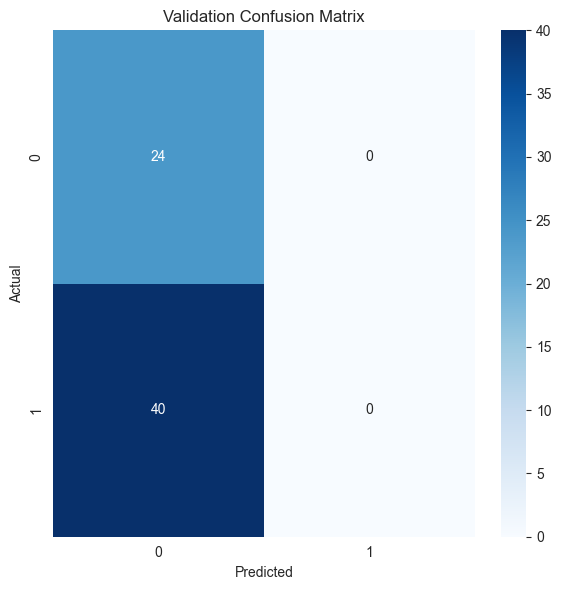

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 264/264 [03:56<00:00,  1.12it/s, v_num=oogs]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]

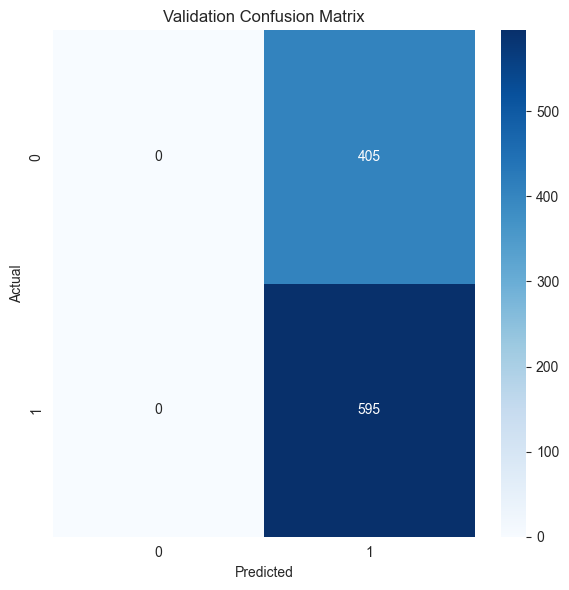


Epoch 1: 100%|██████████| 264/264 [03:54<00:00,  1.12it/s, v_num=oogs, val_loss=0.677, val_acc=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]

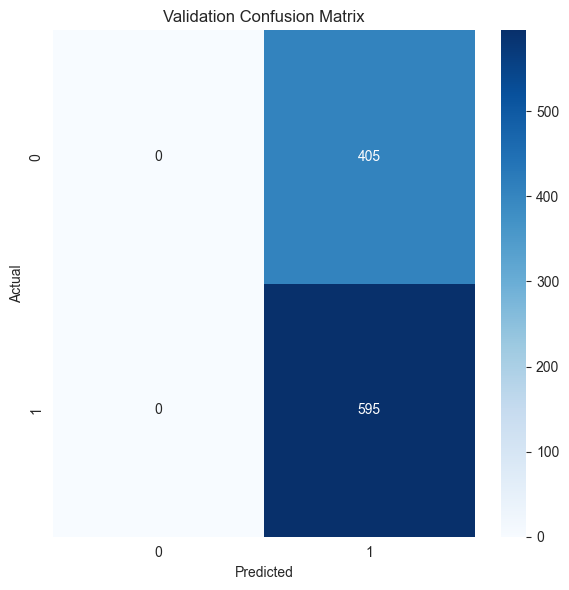


Epoch 2: 100%|██████████| 264/264 [03:53<00:00,  1.13it/s, v_num=oogs, val_loss=0.675, val_acc=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]

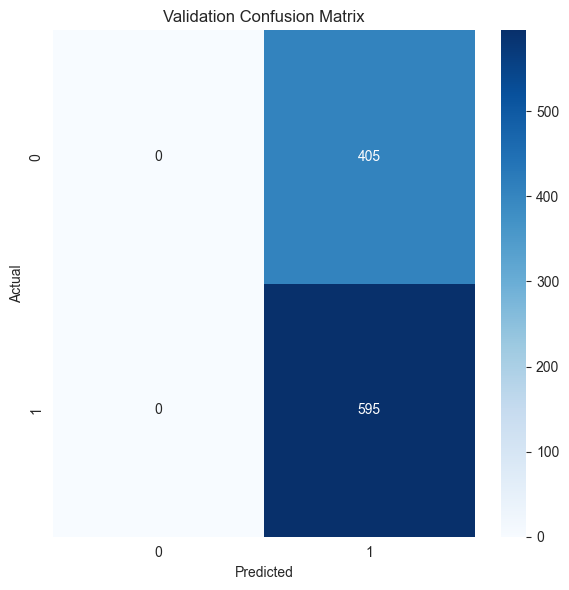


Epoch 3: 100%|██████████| 264/264 [03:54<00:00,  1.13it/s, v_num=oogs, val_loss=0.676, val_acc=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]

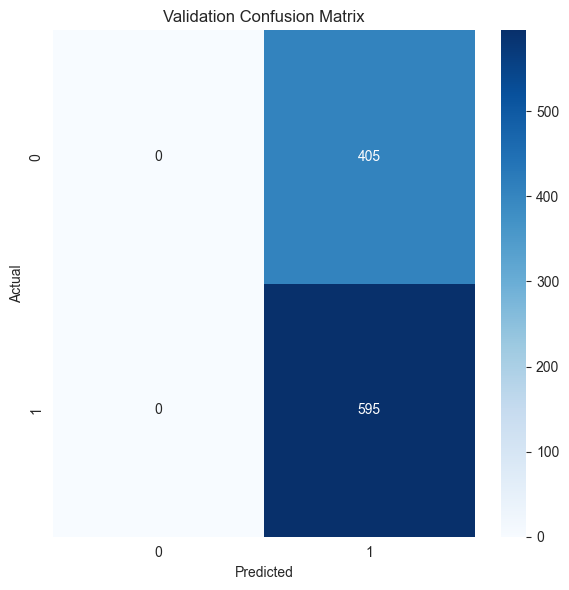


Epoch 4: 100%|██████████| 264/264 [03:51<00:00,  1.14it/s, v_num=oogs, val_loss=0.677, val_acc=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.96it/s]

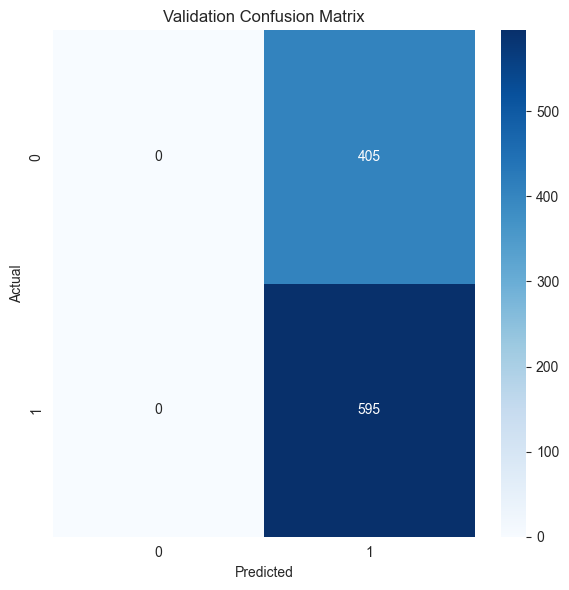


Epoch 5: 100%|██████████| 264/264 [03:52<00:00,  1.14it/s, v_num=oogs, val_loss=0.677, val_acc=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]

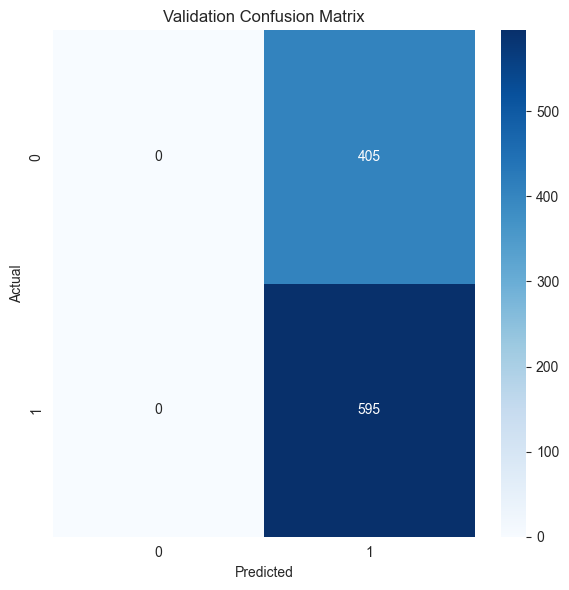


Epoch 6: 100%|██████████| 264/264 [03:54<00:00,  1.12it/s, v_num=oogs, val_loss=0.677, val_acc=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]

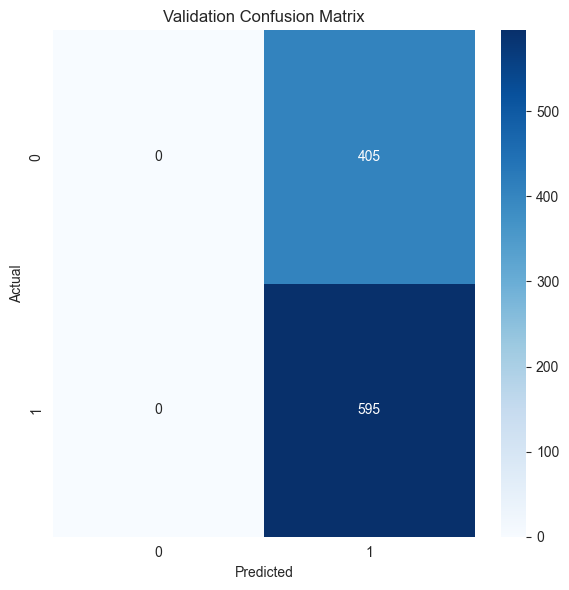


Epoch 6: 100%|██████████| 264/264 [04:03<00:00,  1.08it/s, v_num=oogs, val_loss=0.677, val_acc=0.595]


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
train_acc_epoch,▁██████
train_acc_step,▃▅▃▇▄▅▅▄▅▇▅▁▅▇▆▇▆▄▅▄▆█▇█▄▅▄▄▃▄▇▅▇▅▆▇
train_loss_epoch,█▃▂▁▁▁▁
train_loss_step,▆▅▇▁▅▄▅▆▄▃▅█▅▃▄▃▃▆▅▆▃▁▃▁▅▅▅▅▇▅▂▄▂▅▃▂
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▁▁▁▁▁▁
val_loss,█▁▆▇▆▇▇
epoch,6
train_acc_epoch,0.62644
train_acc_step,0.75


[I 2024-11-25 20:19:07,217] Trial 0 finished with value: 0.5950000286102295 and parameters: {'learning_rate': 0.00042673294272099185, 'hidden_dim': 64, 'dropout_rate': 0.450186204700643, 'weight_decay': 0.0001602953265606038, 'warmup_ratio': 0.08004931382445107}. Best is trial 0 with value: 0.5950000286102295.
C:\Users\Pascal\AppData\Local\Temp\ipykernel_14048\4182833573.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-3),
C:\Users\Pascal\AppData\Local\Temp\ipykernel_14048\4182833573.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "dropout_rate": trial.suggest_uniform("dropout_rate", 0.0, 0.5),
C:\Users\Pascal\App

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\bert_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | bert       | BertModel  | 108 M  | train
1 | classifier | Sequential | 246 K  | train
2 | loss_fn    | BCELoss    | 0      | train
--------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
434.227   Total estimated model params size (MB)
235       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

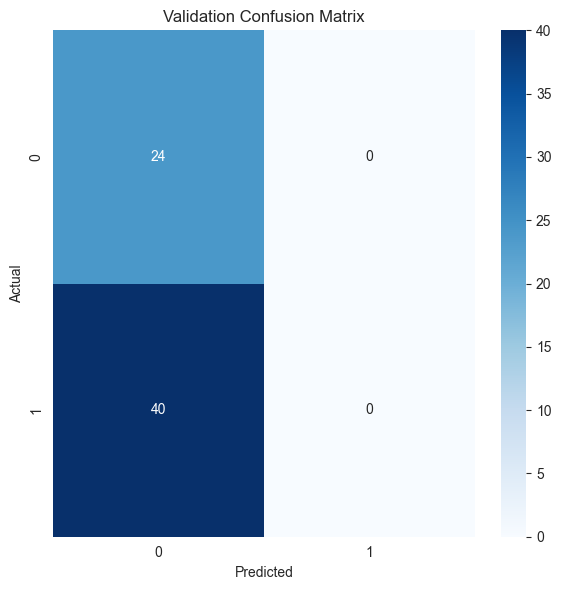

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 264/264 [03:52<00:00,  1.14it/s, v_num=5urb]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]

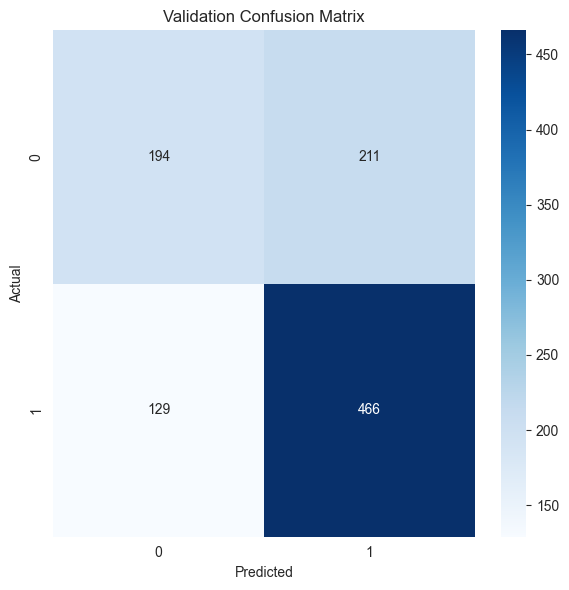


Epoch 1: 100%|██████████| 264/264 [03:51<00:00,  1.14it/s, v_num=5urb, val_loss=0.633, val_acc=0.660]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.91it/s]

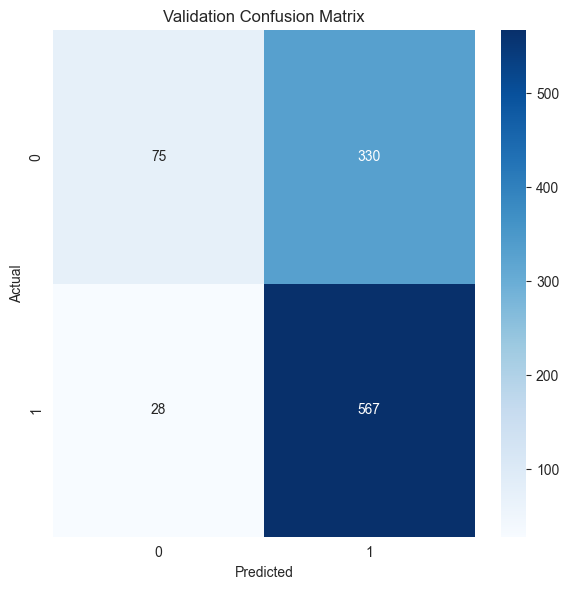


Epoch 2: 100%|██████████| 264/264 [03:54<00:00,  1.13it/s, v_num=5urb, val_loss=0.649, val_acc=0.642]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]

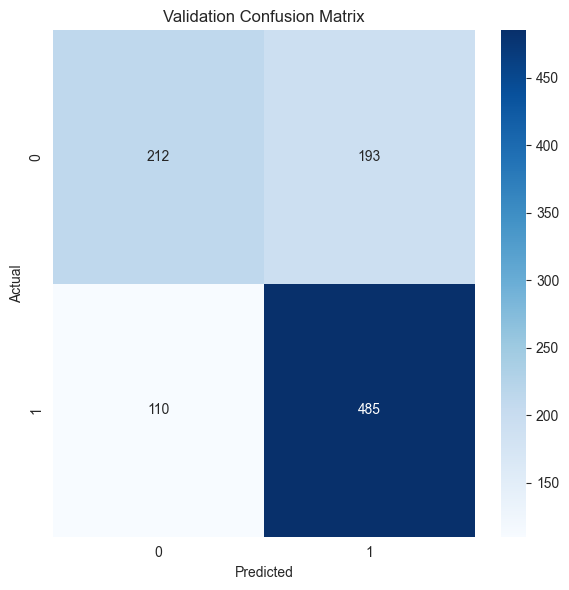


Epoch 3: 100%|██████████| 264/264 [03:52<00:00,  1.13it/s, v_num=5urb, val_loss=0.601, val_acc=0.697]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]

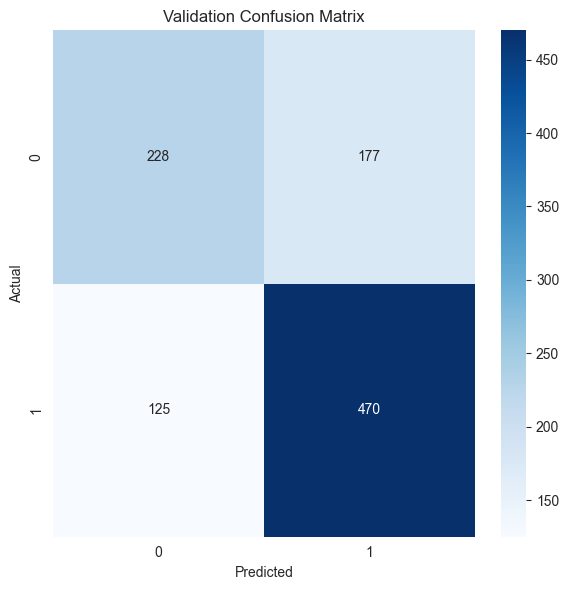


Epoch 4: 100%|██████████| 264/264 [03:54<00:00,  1.13it/s, v_num=5urb, val_loss=0.834, val_acc=0.698]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]

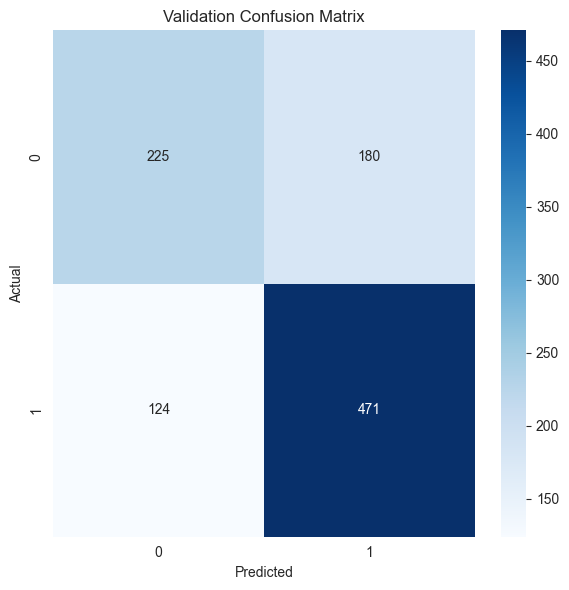


Epoch 5: 100%|██████████| 264/264 [03:51<00:00,  1.14it/s, v_num=5urb, val_loss=0.840, val_acc=0.696]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

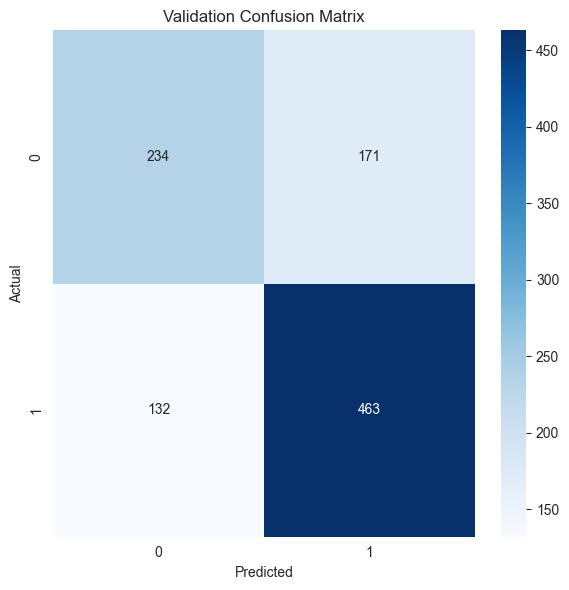


Epoch 6: 100%|██████████| 264/264 [03:52<00:00,  1.14it/s, v_num=5urb, val_loss=0.983, val_acc=0.697]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]

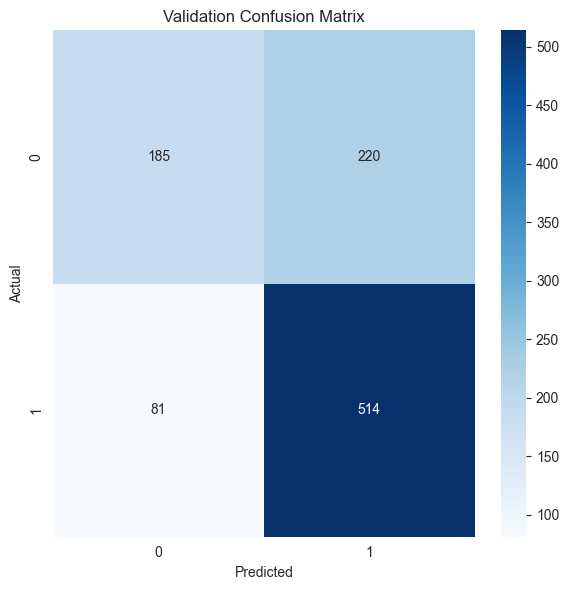


Epoch 7: 100%|██████████| 264/264 [03:53<00:00,  1.13it/s, v_num=5urb, val_loss=1.400, val_acc=0.699]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]

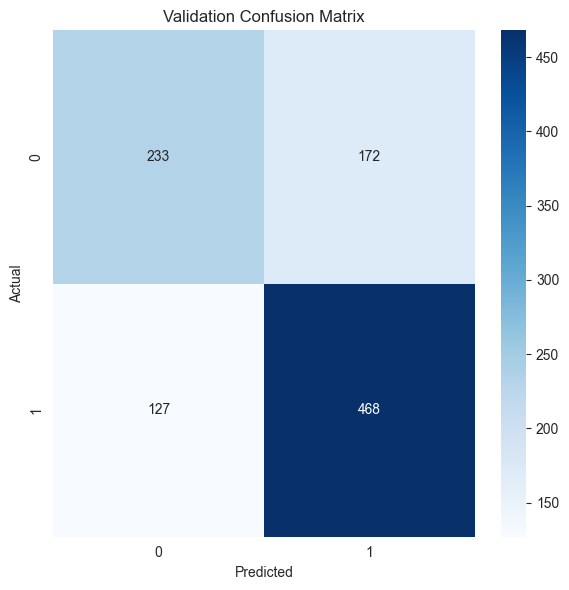


Epoch 7: 100%|██████████| 264/264 [04:06<00:00,  1.07it/s, v_num=5urb, val_loss=1.310, val_acc=0.701]


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
train_acc_epoch,▁▂▄▅▇███
train_acc_step,▃▃▃▁▁▄▂▅▆▃▄▃▃▅▄▆▇▆▅▅▇▇█▅▇▇███▇▇█████████
train_loss_epoch,█▇▆▄▃▂▁▁
train_loss_step,▇▇▇██▆▇▆▆▇▆▇▇▅▇▅▄▄▅▄▃▃▂▇▃▂▁▁▁▂▃▁▁▁▁▁▁▁▁▃
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
val_acc,▃▁██▇███
val_loss,▁▁▁▃▃▄█▇
epoch,7
train_acc_epoch,0.98908
train_acc_step,0.96875


[I 2024-11-25 20:54:02,159] Trial 1 finished with value: 0.7009999752044678 and parameters: {'learning_rate': 8.475470130130413e-05, 'hidden_dim': 320, 'dropout_rate': 0.19612044227845693, 'weight_decay': 0.00015314423112601527, 'warmup_ratio': 0.06791851518895996}. Best is trial 1 with value: 0.7009999752044678.
C:\Users\Pascal\AppData\Local\Temp\ipykernel_14048\4182833573.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-3),
C:\Users\Pascal\AppData\Local\Temp\ipykernel_14048\4182833573.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "dropout_rate": trial.suggest_uniform("dropout_rate", 0.0, 0.5),
C:\Users\Pascal\

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\bert_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | bert       | BertModel  | 108 M  | train
1 | classifier | Sequential | 344 K  | train
2 | loss_fn    | BCELoss    | 0      | train
--------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
434.621   Total estimated model params size (MB)
235       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

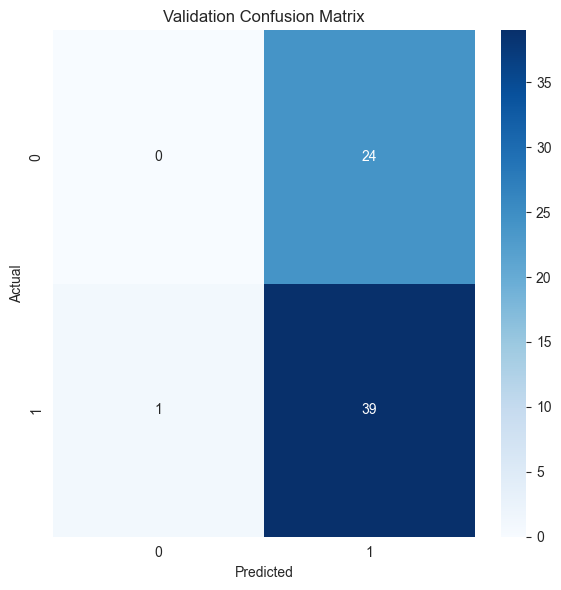

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 264/264 [03:50<00:00,  1.14it/s, v_num=l77q]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]

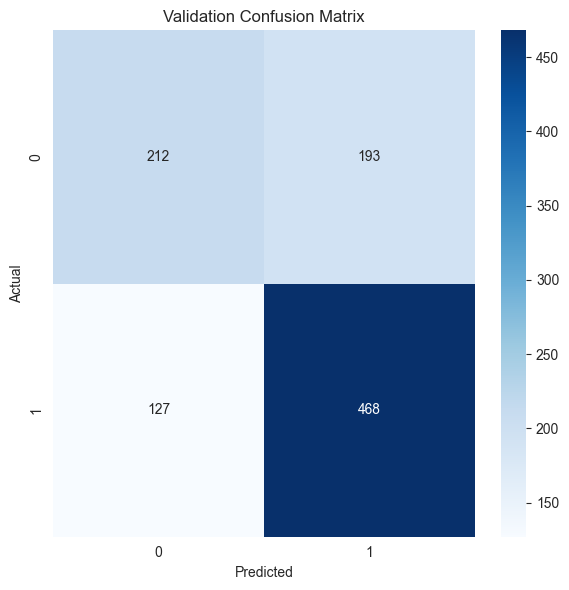


Epoch 1: 100%|██████████| 264/264 [03:51<00:00,  1.14it/s, v_num=l77q, val_loss=0.609, val_acc=0.680]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]

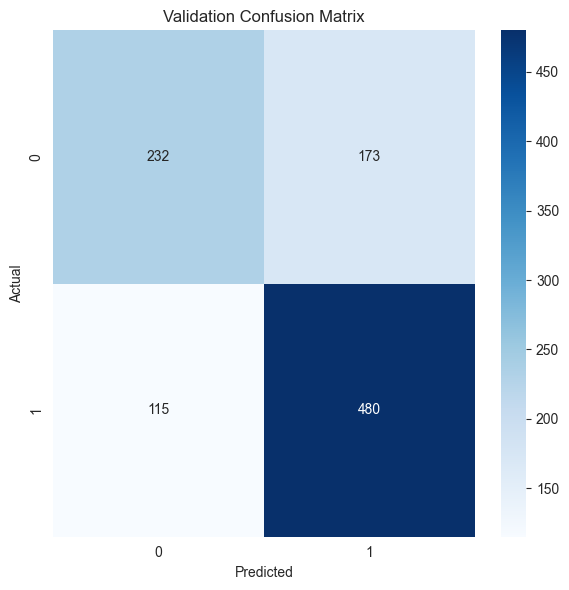


Epoch 2: 100%|██████████| 264/264 [03:53<00:00,  1.13it/s, v_num=l77q, val_loss=0.559, val_acc=0.712]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]

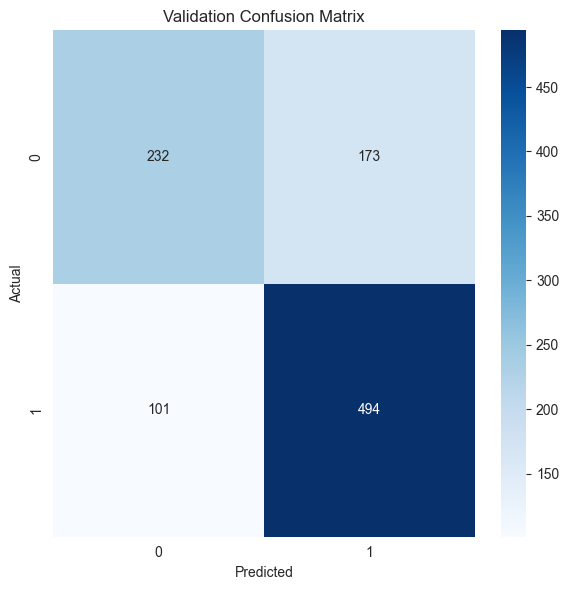


Epoch 3: 100%|██████████| 264/264 [03:52<00:00,  1.14it/s, v_num=l77q, val_loss=0.710, val_acc=0.726]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]

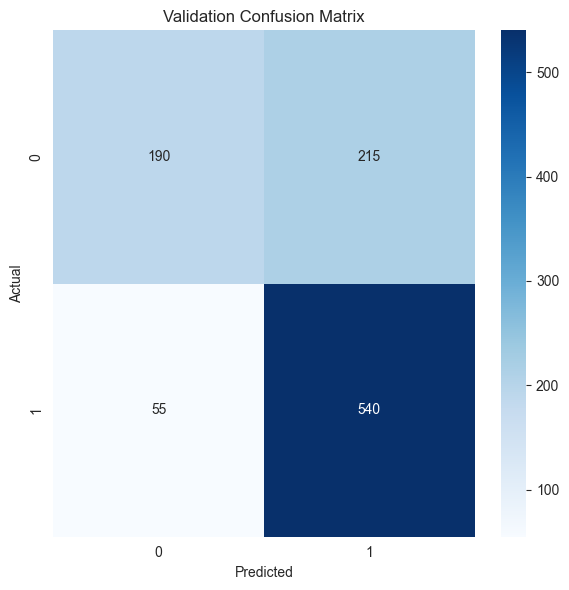


Epoch 4: 100%|██████████| 264/264 [03:52<00:00,  1.14it/s, v_num=l77q, val_loss=0.998, val_acc=0.730]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]

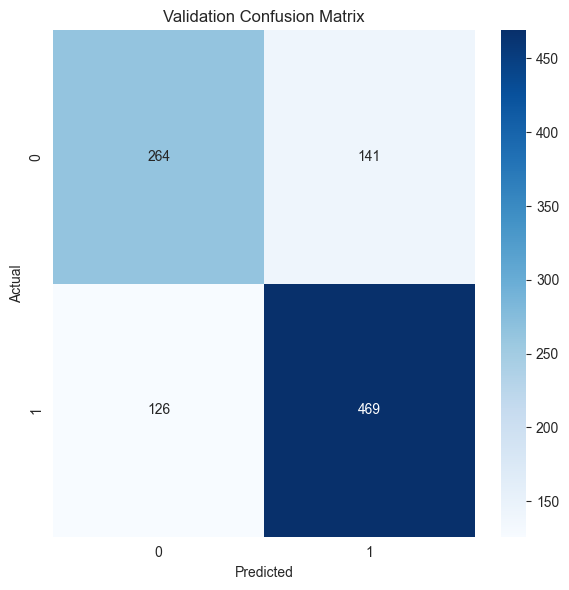


Epoch 5: 100%|██████████| 264/264 [03:52<00:00,  1.14it/s, v_num=l77q, val_loss=1.000, val_acc=0.733]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]

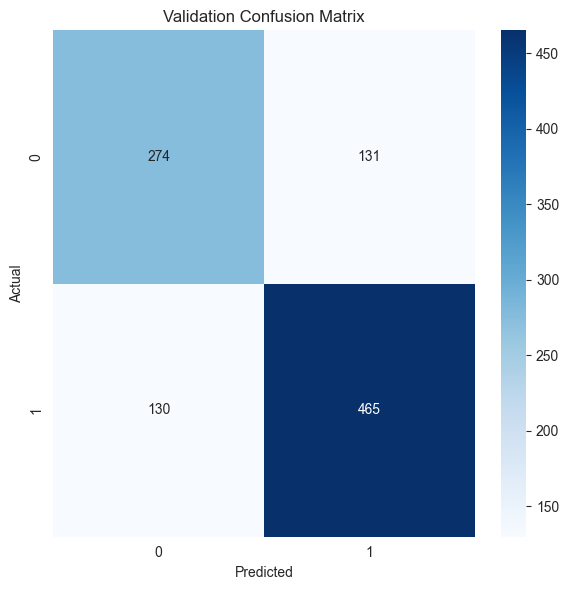


Epoch 6: 100%|██████████| 264/264 [03:53<00:00,  1.13it/s, v_num=l77q, val_loss=1.320, val_acc=0.739]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]

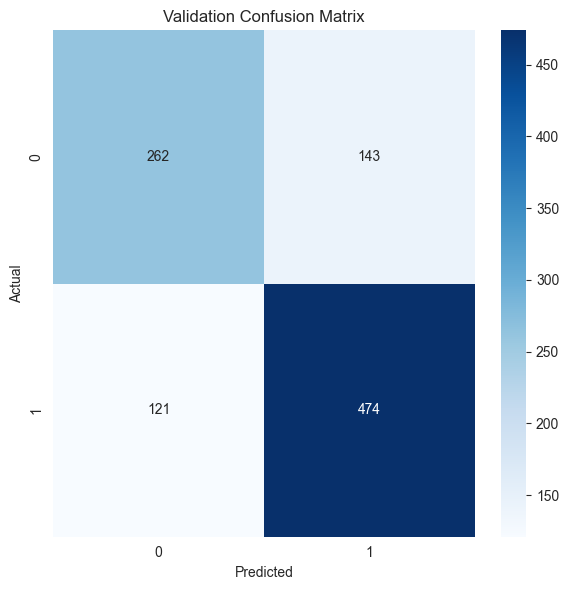


Epoch 6: 100%|██████████| 264/264 [04:01<00:00,  1.09it/s, v_num=l77q, val_loss=1.420, val_acc=0.736]


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
train_acc_epoch,▁▃▅▇███
train_acc_step,▁▃▁▃▂▄▅▄▅▅▅▂▅▆▅▆▆▆▇▇▆█▇▇▇▇▇▇▇█▇▇█▇█▇
train_loss_epoch,█▇▅▃▂▁▁
train_loss_step,█▇█▇▇▇▆▇▆▆▃█▅▄▅▃▃▃▂▂▃▁▃▁▄▂▂▂▂▁▁▃▁▁▁▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
val_acc,▁▅▆▇▇██
val_loss,▁▁▂▅▅▇█
epoch,6
train_acc_epoch,0.98754
train_acc_step,0.96875


[I 2024-11-25 21:24:53,808] Trial 2 finished with value: 0.7360000014305115 and parameters: {'learning_rate': 3.233413438380264e-05, 'hidden_dim': 448, 'dropout_rate': 0.20766842736826918, 'weight_decay': 7.370027643649387e-05, 'warmup_ratio': 0.08159326264046585}. Best is trial 2 with value: 0.7360000014305115.
C:\Users\Pascal\AppData\Local\Temp\ipykernel_14048\4182833573.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-3),
C:\Users\Pascal\AppData\Local\Temp\ipykernel_14048\4182833573.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "dropout_rate": trial.suggest_uniform("dropout_rate", 0.0, 0.5),
C:\Users\Pascal\A

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\bert_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | bert       | BertModel  | 108 M  | train
1 | classifier | Sequential | 98.6 K | train
2 | loss_fn    | BCELoss    | 0      | train
--------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.635   Total estimated model params size (MB)
235       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

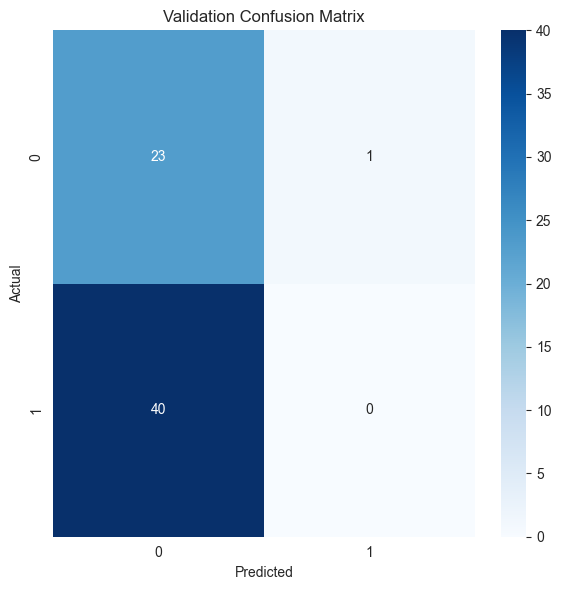

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 264/264 [03:52<00:00,  1.14it/s, v_num=kx0h]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.94it/s]

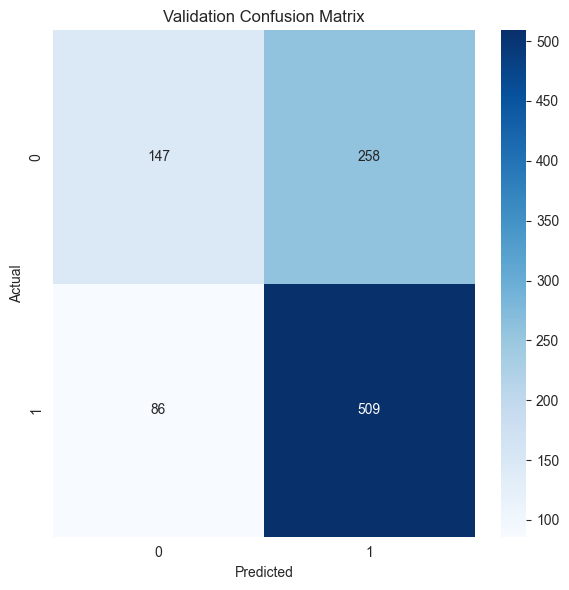


Epoch 1: 100%|██████████| 264/264 [03:51<00:00,  1.14it/s, v_num=kx0h, val_loss=0.630, val_acc=0.656]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]

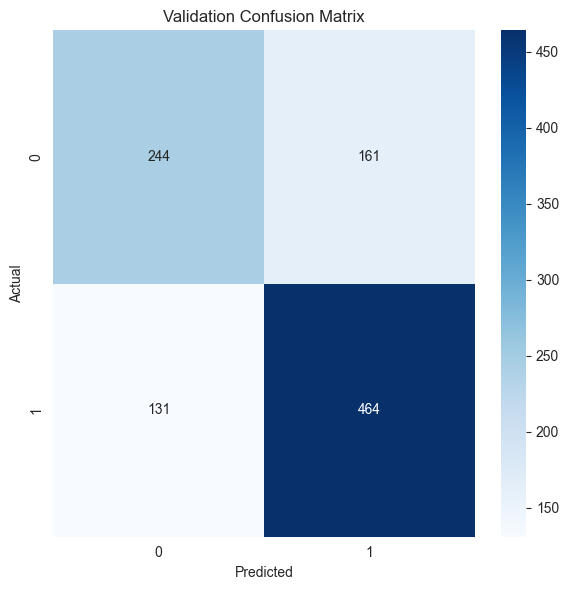


Epoch 2: 100%|██████████| 264/264 [03:52<00:00,  1.14it/s, v_num=kx0h, val_loss=0.573, val_acc=0.708]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]

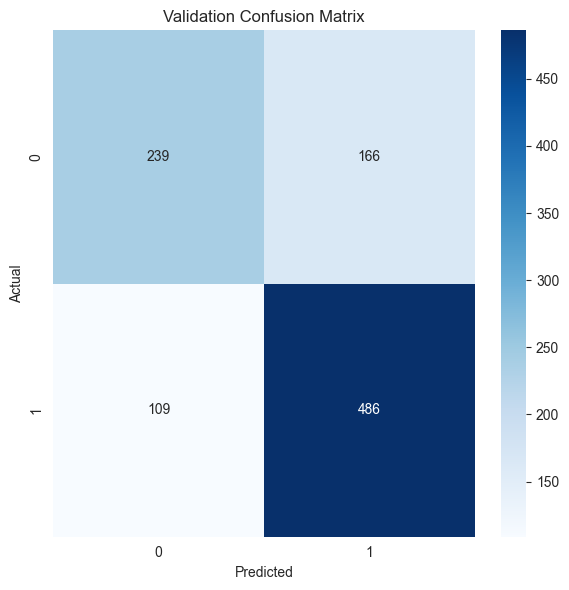


Epoch 3: 100%|██████████| 264/264 [03:51<00:00,  1.14it/s, v_num=kx0h, val_loss=0.603, val_acc=0.725]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]

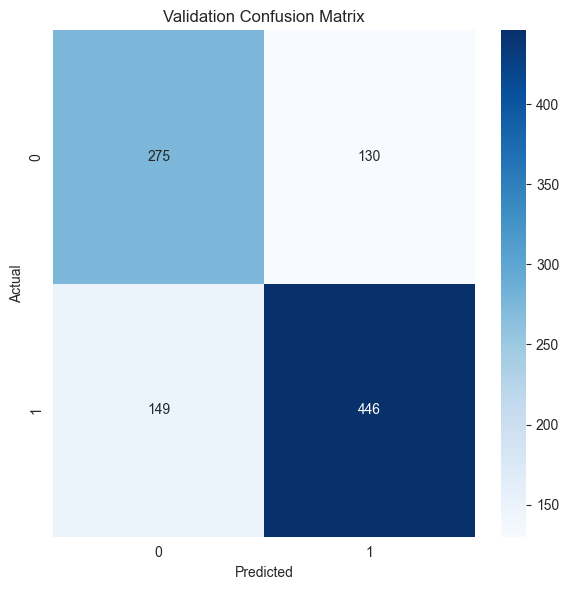


Epoch 4: 100%|██████████| 264/264 [03:53<00:00,  1.13it/s, v_num=kx0h, val_loss=0.766, val_acc=0.721]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]

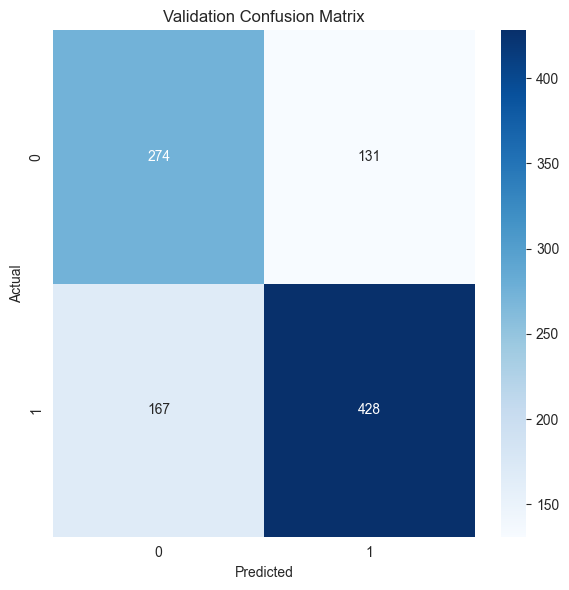


Epoch 5: 100%|██████████| 264/264 [03:54<00:00,  1.13it/s, v_num=kx0h, val_loss=1.120, val_acc=0.702]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]

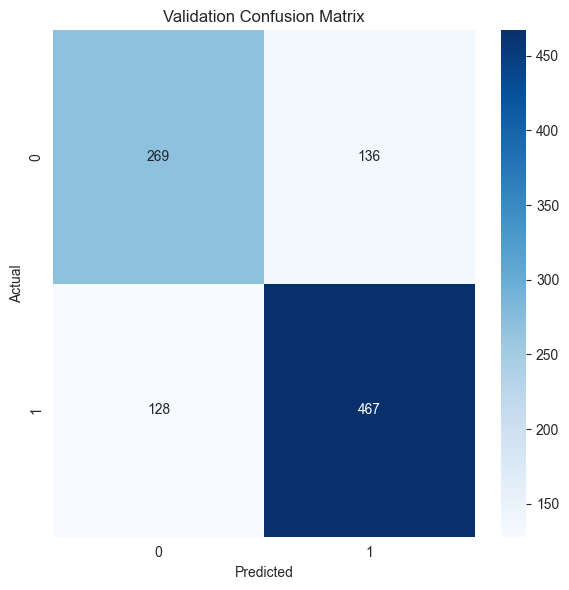


Epoch 6: 100%|██████████| 264/264 [03:52<00:00,  1.14it/s, v_num=kx0h, val_loss=1.190, val_acc=0.736]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]

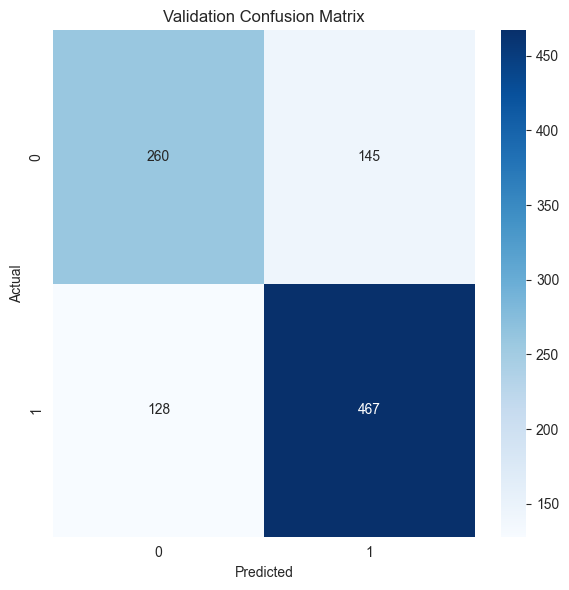


Epoch 6: 100%|██████████| 264/264 [04:01<00:00,  1.09it/s, v_num=kx0h, val_loss=1.340, val_acc=0.727]


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train_acc_epoch,▁▃▅▆▇██
train_acc_step,▂▄▃▁▆▄▆▃▅▃▆▅▆▇▄▇█▇▇▆█▇███▇▇█████████
train_loss_epoch,█▇▅▃▂▁▁
train_loss_step,█▇██▆▆▇▇▇▇▄▆▅▃▇▃▂▃▄▄▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▆▇▇▅█▇
val_loss,▂▁▁▃▆▇█
epoch,6
train_acc_epoch,0.98457
train_acc_step,0.96875


[I 2024-11-25 21:55:39,460] Trial 3 finished with value: 0.7269999980926514 and parameters: {'learning_rate': 1.979518002008204e-05, 'hidden_dim': 128, 'dropout_rate': 0.10713812551750279, 'weight_decay': 2.1789087247869856e-05, 'warmup_ratio': 0.011703048542611972}. Best is trial 2 with value: 0.7360000014305115.
C:\Users\Pascal\AppData\Local\Temp\ipykernel_14048\4182833573.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-3),
C:\Users\Pascal\AppData\Local\Temp\ipykernel_14048\4182833573.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "dropout_rate": trial.suggest_uniform("dropout_rate", 0.0, 0.5),
C:\Users\Pascal

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\bert_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | bert       | BertModel  | 108 M  | train
1 | classifier | Sequential | 295 K  | train
2 | loss_fn    | BCELoss    | 0      | train
--------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
434.424   Total estimated model params size (MB)
235       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

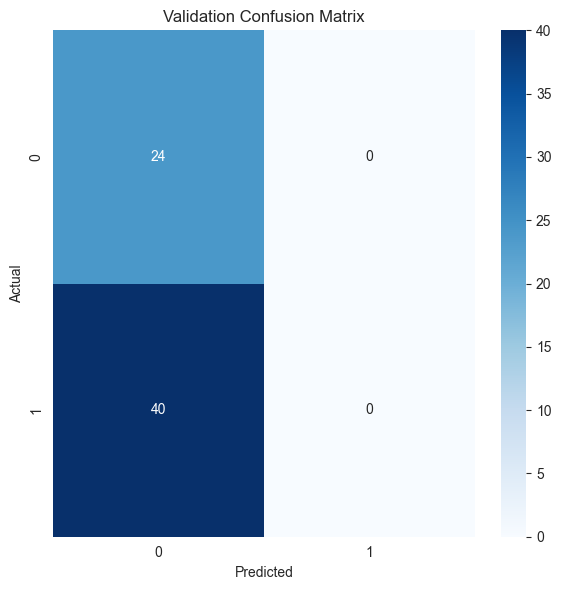

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 264/264 [03:55<00:00,  1.12it/s, v_num=hy7g]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]

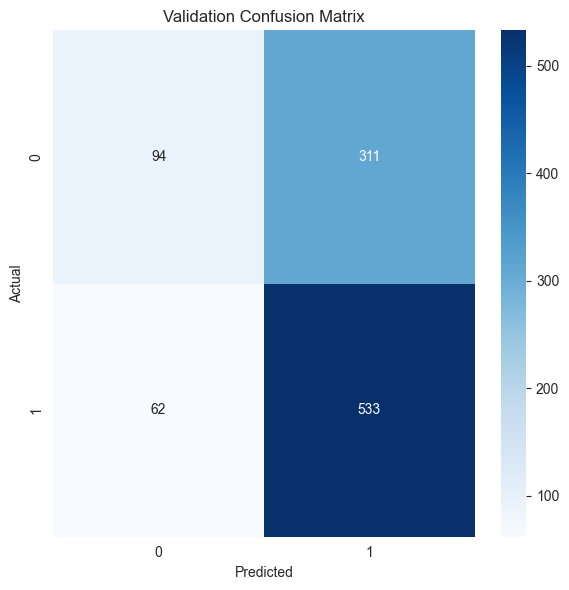


Epoch 1: 100%|██████████| 264/264 [03:53<00:00,  1.13it/s, v_num=hy7g, val_loss=0.640, val_acc=0.627]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]

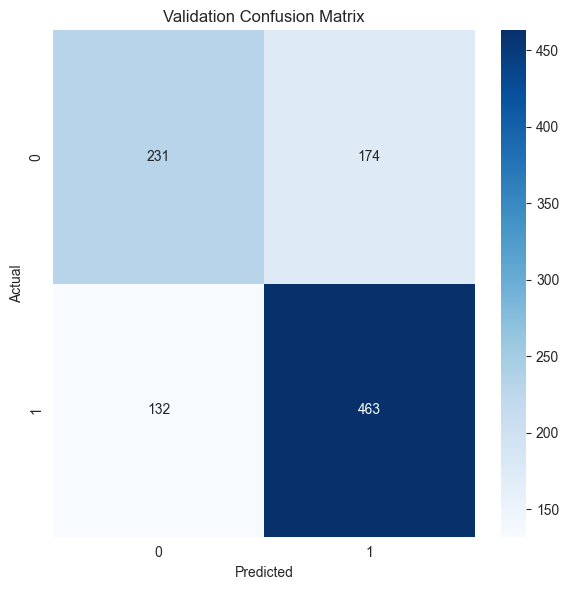


Epoch 2: 100%|██████████| 264/264 [03:53<00:00,  1.13it/s, v_num=hy7g, val_loss=0.590, val_acc=0.694]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]

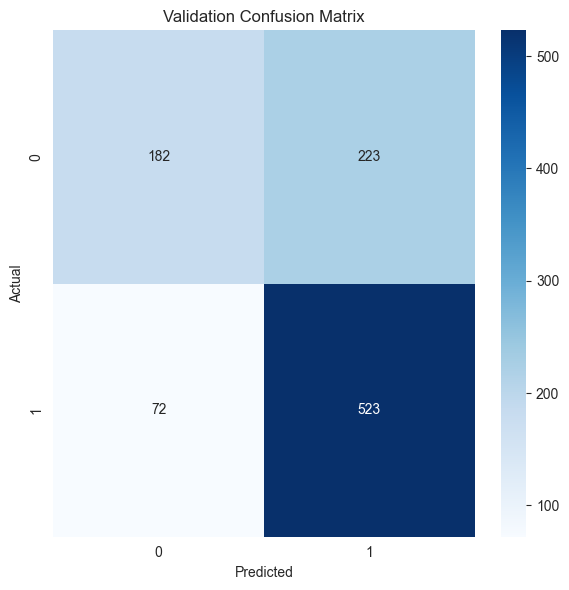


Epoch 3: 100%|██████████| 264/264 [03:53<00:00,  1.13it/s, v_num=hy7g, val_loss=0.637, val_acc=0.705]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]

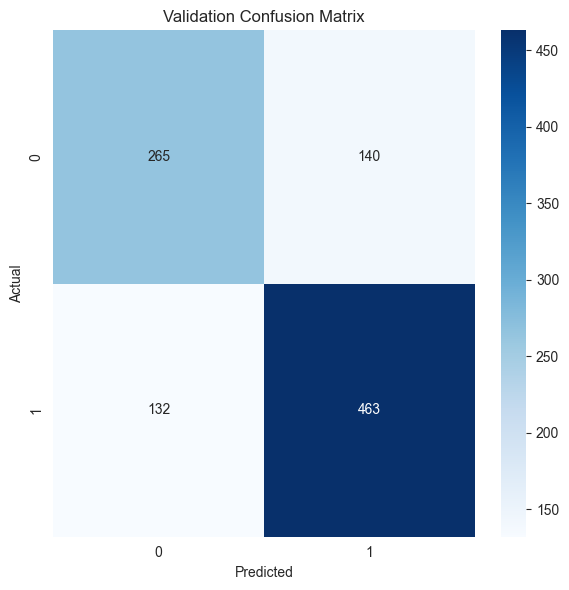


Epoch 4: 100%|██████████| 264/264 [03:54<00:00,  1.13it/s, v_num=hy7g, val_loss=0.646, val_acc=0.728]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]

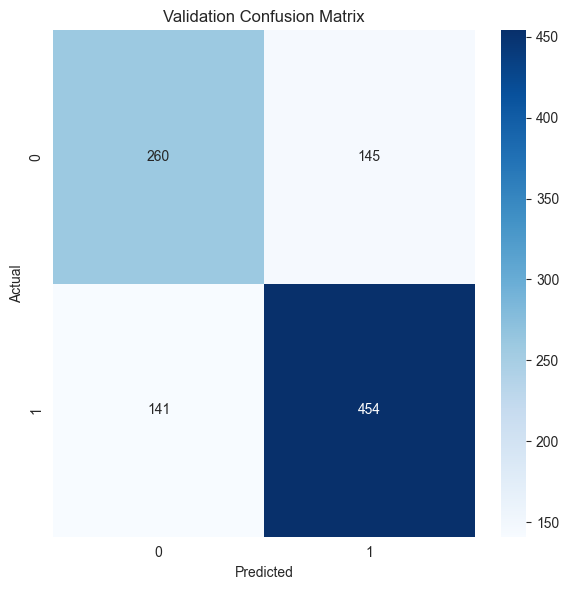


Epoch 5: 100%|██████████| 264/264 [03:53<00:00,  1.13it/s, v_num=hy7g, val_loss=0.822, val_acc=0.714]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.94it/s]

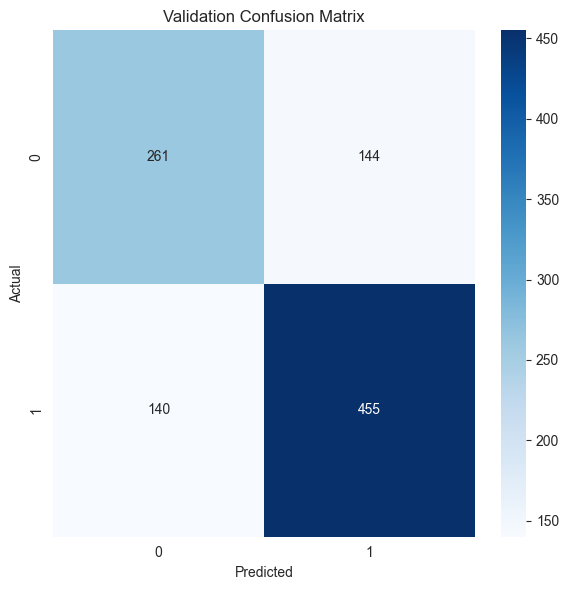


Epoch 6: 100%|██████████| 264/264 [03:54<00:00,  1.13it/s, v_num=hy7g, val_loss=0.974, val_acc=0.716]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]

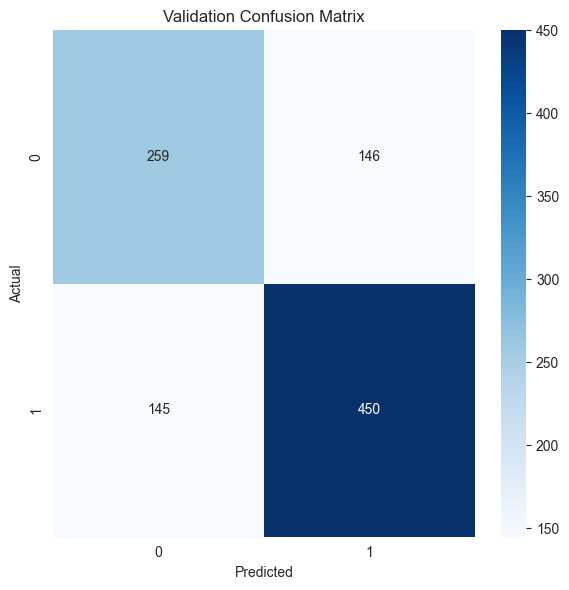


Epoch 6: 100%|██████████| 264/264 [04:03<00:00,  1.08it/s, v_num=hy7g, val_loss=1.210, val_acc=0.709]


epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train_acc_epoch,▁▂▄▆▇██
train_acc_step,▁▃▄▂▃▄▄▃▄▇▅▄▆▅▅▅▇▇▅▇▇█▆▇▇▇█▇█▇▇████▇
train_loss_epoch,█▇▆▄▃▂▁
train_loss_step,█▇▇█▇▇▆▆▆▅▅▆▅▅▆▅▂▄▅▄▄▂▄▃▃▃▁▂▂▃▂▁▁▂▁▃
trainer/global_step,▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▆▆█▇▇▇
val_loss,▂▁▂▂▄▅█
epoch,6
train_acc_epoch,0.96891
train_acc_step,0.9375


[I 2024-11-25 22:26:36,563] Trial 4 finished with value: 0.7089999914169312 and parameters: {'learning_rate': 1.1627970769254771e-05, 'hidden_dim': 384, 'dropout_rate': 0.24994080876228697, 'weight_decay': 0.0005082511263755801, 'warmup_ratio': 0.0943501311725854}. Best is trial 2 with value: 0.7360000014305115.


Best hyperparameters: {'learning_rate': 3.233413438380264e-05, 'hidden_dim': 448, 'dropout_rate': 0.20766842736826918, 'weight_decay': 7.370027643649387e-05, 'warmup_ratio': 0.08159326264046585}
Best value: 0.7360000014305115


best_value,▁
trainer/global_step,▁
best_value,0.736
trainer/global_step,0


In [11]:
# run_optuna()

## Evaluation
The percentage of yes answers in each data split is: Train; 62.64%, Val; 59.50%, Test;62.17%
Seeing how difficult it was in past projects to reach a much better accuracy than the baseline majority class I am setting my goal for the pretrained BERT model at 64% accuracy on the test set.


### Error Analysis
To understand why the model may fail on certain predictions, I will conduct an error analysis investigating weather miss classifications are related to the confidence score the model has in its predictions. Low confidence on correct answers or high confidence on wrong answers may indicate areas where the model is uncertain or overconfident.


### Confusion Matrix
After the validation step, a confusion matrix is computed to assess true positives, false positives, true negatives, and false negatives. This provides insights into the model's prediction performance.


## Planned Correctness Tests
- Visually checking for decreasing loss during training.
- Verifying predictions with a confusion matrix.

## Interpretation

My last project went decently well, beating the majority class accuracy of 62.17% on the test set. Before writing this interpretation i toyed around with the `bert-large-cased` model, implementing and running it as quickly as possible just to see what it could do. With 333 Million parameters in the transformer model I had to use a `batch_size` of 16 to not run out of memory. Giving it a single run over the weekend, with "looks about right" choice for hyperparameters, it managed to reach a test accuracy of 72.63% after over 23 hours of runtime. Impressed by this result I am setting my expectations for the properly implemented and fine-tuned `bert-base-cased` model to reach a test accuracy of 69%. Nice.